# 8. FFT and image processing

This lesson will cover two aspects of scientific computing:
<ul>
    <li> making use of previously developed code; and
    <li> visualizing numerical data as images.
</ul>

As an example, we will explore the ideas of <a href="https://elad.cs.technion.ac.il/wp-content/uploads/2018/02/30_PolarFFT_ACHA.pdf" target="_blank">this paper</a> (A. Averbuch, R. Coifman, D.L. Donoho, M. Elad, and M. Israeli, Fast and Accurate Polar Fourier Transform, <i>Journal on Applied and Computational Harmonic Analysis</i>, Vol. 21, pp.145-167, 2006, code by &copy; M.Elad et al., 2005) on optimising FFT in polar coordinates.  The students are expected to read and report on the main ideas of the paper in the preparation of their project.

In [1]:
%plot --format png -w 900 -h 600

Matlab/Octave have a library of basic image manipulation routines, and many extensions have been developed by users that can be loaded and made use of.  For examples, check out <a href="https://octave.sourceforge.io/packages.php" target="_blank">https://octave.sourceforge.io/packages.php</a>.

Depending on whether the package you are interested is installed or not, you may simply issue the calling command, or first download and install it.  Typically, you download and save the package file (e.g. the current <tt>image</tt> package is <tt>image-2.14.0.tar.gz</tt>), and then install it like this:
<pre>
  pkg install image
</pre>  
When you run it as a non-privileged user, it gets installed into your own filespace only.

After the package is installed, you may need to explicitly load it into your script, by specifying somewhere close to the beginning of the script:
<pre>
  pkg load image
</pre>

Note that the <tt>image</tt> package used above as an example is actually already installed on our cluster and these specific commands should not be necessary.

To begin with, let's see how a matrix of numbers can be viewed as an image, and how an image can be imported and converted into a matrix of numbers.

In [2]:
pkg list

Package Name  | Version | Installation directory
--------------+---------+-----------------------
     control  |   3.2.0 | /usr/local/share/octave/packages/control-3.2.0
   dataframe  |   1.2.0 | /home/esternin/octave/dataframe-1.2.0
       image  |   2.6.2 | /usr/local/share/octave/packages/image-2.6.2
          io  |   2.6.4 | /home/esternin/octave/io-2.6.4
     matgeom  |   1.2.3 | /home/esternin/octave/matgeom-1.2.3
       optim  |   1.5.2 | /usr/local/share/octave/packages/optim-1.5.2
      signal  |   1.4.1 | /usr/local/share/octave/packages/signal-1.4.1
  statistics  |   1.4.2 | /home/esternin/octave/statistics-1.4.2
      struct  |  1.0.14 | /usr/local/share/octave/packages/struct-1.0.14


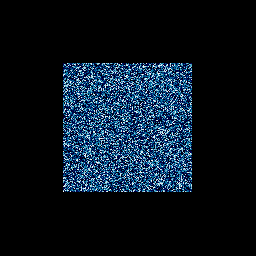

In [3]:
clear;
N=128;                % the size of the image will be 2N x 2N, -N..+N in both x and y
m = zeros(2*N);
f=1/2;                % fraction of the image to be filled with random numbers 
blob=N+[-f*N:f*N];    % create a subindex into the central portion of the image

m(blob,blob) += rand(size(m(blob,blob)));  % fill this portion with random numbers 
imagesc(m);           % show the image

%colormap(gray(255)); % try different colour maps; this is 8-bit gray
colormap('ocean');    % colormap traversing black->blue->cyan->white
%colormap('jet');      % colormap traversing blue->cyan->green->yellow->red

% colour = intensity, https://octave.sourceforge.io/octave/function/colormap.html

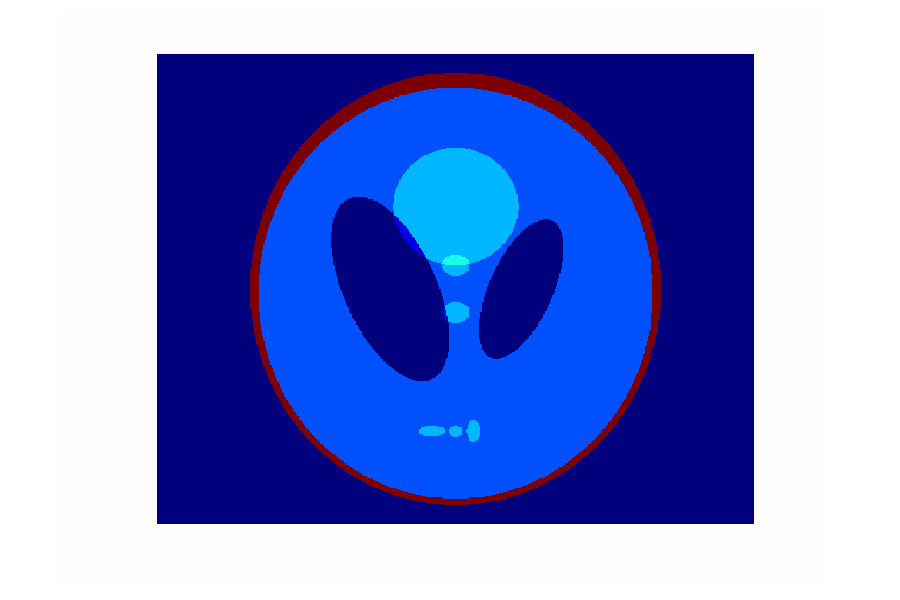

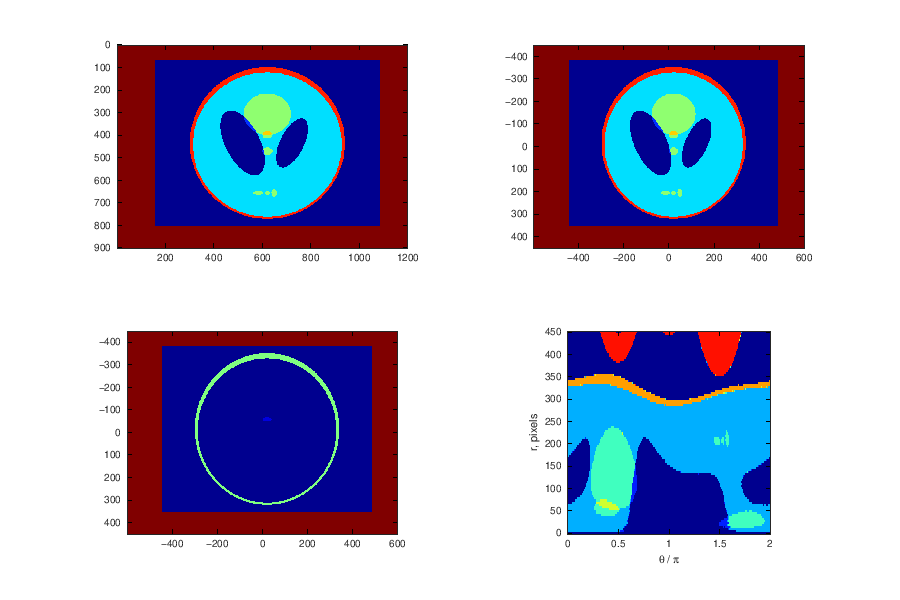

In [4]:
% sometimes, the image already exists, locally or on the net
I_in=imread("http://i.stack.imgur.com/HYSyb.png");

figure(1);
imshow(I_in);   % this will display pixel-for-pixel, without rescaling

figure(2);      % can show 4 images as a 2x2 array of (scaled to fit) plots
subplot(2,2,1); % the SCaled original image is the first of the four
[I, cmap] = rgb2ind(I_in); % convert rgb image into a 2D (INDexed) array of intensities
imagesc(I);  

subplot(2,2,2);
[r, c,~] = size(I_in);     % (0,0) is at top left, but we can change that
x = (1:c)-(c/2);           % (0,0) is now in the center of the image
y = (1:r)-(r/2);
imagesc(x,y,I);            % use arrays x,y to index it
pbaspect([1 r/c 1]);       % rows/columns ratio is the aspect ratio of the axes

%colormap(gray(255));
%colormap('ocean');
colormap('jet');

%% there are many image transformations and manipulations possible

% e.g., can show just one of the colour channels: the third index is RGB
% this is just an array of red intensities, displayed in the current colourmap
subplot(2,2,3);
imagesc(x,y,I_in(:,:,1)); % 1 selects the R channel, 2=G, 3=B
pbaspect([1 r/c 1]);

%% this is a more complex example: convert the image from (x,y) into polar form (r,theta)

% create destination coordinates in polar form: r=0..N, theta=0..2*pi
N=min(r/2,c/2);  % choose the smaller of the two dimensions, so that all theta are known
                 % the new grid is NxN
[r th] = meshgrid(linspace(0,2*pi,N),linspace(0,N));
% translate grid coordinates from polar to cartesian (image pixels) coordinates
[xx,yy] = pol2cart(r,th);
% interpolate image pixel values to the new grid coordinates
I_out = interp2(x,y,I,xx,yy);

subplot(2,2,4);
imagesc(linspace(2,0,N),linspace(0,N),I_out); % convert theta to +ve ccw
xlabel("\\theta / \\pi"); ylabel("r, pixels"); pbaspect([1 1 1]); axis('xy');

% save the result to a file
%imwrite(I_out, cmap, "HYSyb-polar.png");

In [ ]:
%% do this the first time
cd ~/5P10
%system("wget https://elad.cs.technion.ac.il/wp-content/uploads/2018/02/PolarLab.zip");
%% or use the local copy:
system("cp /work/5P10/Lectures/PolarLab.zip ./");
system("unzip -x -q -o -d PolarLab PolarLab.zip");
cd PolarLab

In [5]:
%% on subsequent runs, do this
cd ~/5P10/PolarLab
addpath("~/5P10/PolarLab")

In [6]:
% ref: https://elad.cs.technion.ac.il/wp-content/uploads/2018/02/30_PolarFFT_ACHA.pdf

%=====================================================================
% This function performs a Recto (Pseudo) Polar transform on a 2D signal X given on a 
% Cartesian grid. If X is N*N, the output will have 2NS1 by 2NS2 output
% values. If the input is not square, it is squared before the transform.
% Also, the size is increased so as to get even number of rows and columns.
%   
% Synopsis: Y=PPFFT(X,S1,S2)
%
% Inputs -  X      N*N matrix in cartesian grid, (n is assumed to be even)   
%                  S1   oversampling factor along the rays
%                  S2   oversampling factor along the slopes (e.g. angles)
% Outputs - Y      (2*S1*N)*(2*S2*N) matrix (theta,r)
%
% Example: 
%       This shows that the obtained transform matches the brute-force one
%       N=64; X=randn(N,N); X(N/4:3*N/4,N/4:3*N/4)=1;
%       [XC,YC]=Create_Oversampled_Grid('D',[N,pi,5,3],'.r');
%       tic; Y_slow=Brute_Force_Transform(X,XC,YC); toc;
%       tic; Y_fast=PPFFT(X,5,3); toc;
%       figure(1);
%       subplot(2,2,1); imagesc(real(Y_fast)); xlabel('Fast - real part');
%       subplot(2,2,2); imagesc(imag(Y_fast)); xlabel('Fast - imaginary part');
%       subplot(2,2,3); imagesc(real(Y_slow)); xlabel('Slow - real part');
%       subplot(2,2,4); imagesc(imag(Y_slow)); xlabel('Slow - imaginary part');
%       disp(['Error between fast and slow: ',num2str(max(abs(Y_fast(:)-Y_slow(:))))]);
%
%       This shows the relation between the PPFFT and the matrix transform 
%       N=16; X=randn(N,N)+sqrt(-1)*randn(N,N);
%       tic; Yf=PPFFT(X,2,2); toc;
%       [xc,yc]=Create_Oversampled_Grid('D',[N,pi,2,2],'');
%       tic; T=Transform_Matrix(N,N,xc,yc); toc;
%       Yc=T*X(:);
%       plot([real(Yf)-real(reshape(Yc,[4*N,4*N]))']); % there is a transpose relation
%       plot([imag(Yf)-imag(reshape(Yc,[4*N,4*N]))']); % there is a transpose relation
% 
% Written on March 20th, 2005 by Michael Elad.
%=====================================================================

Elapsed time is 2.02939 seconds.
Elapsed time is 1.95175 seconds.


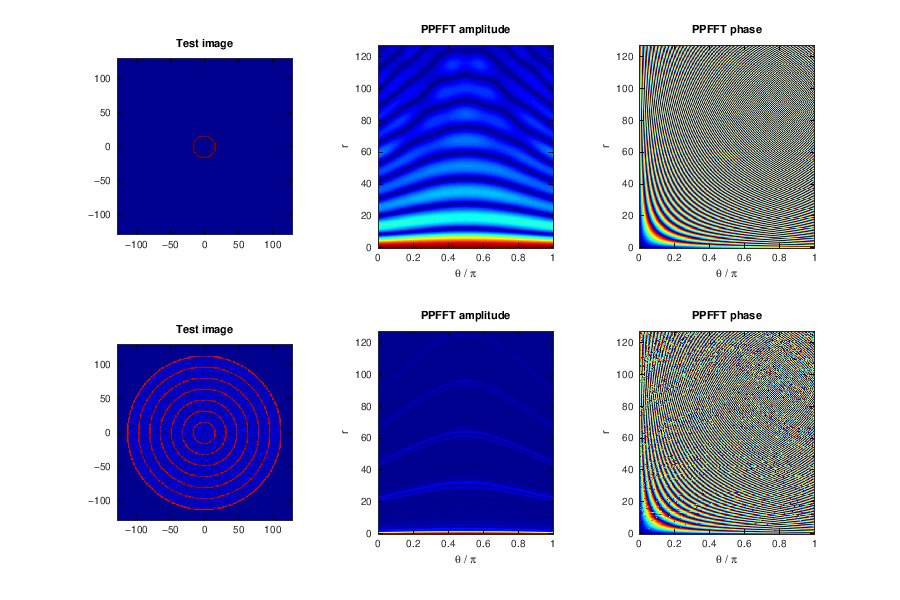

In [7]:
clear;

% could load a previously prepared image like this
%[img, cmap] = imread("alligator.png");
%I=imcomplement(imresize(img,0.25));

% or make a test image, zero filled on all sides
N=128;

% PPFFT setting, useful range = 1..5
oversample=3;

% real 2N x 2N data on input implies a zero imaginary 2N x 2N,
% and then PPFFT produces four identical quadrants NxN each; 
% take one and reshuffle so that r=0,theta=0 is at the lower left of the plot
t_shuffle=[oversample*2*N:-1:1];
r_shuffle=[oversample*2*N:-1:oversample*N];

m = zeros(2*N);
f=[1:7]/8;
blob=[-f(1)*N:f(1)*N];

% the quickest test image is some noise in a square region in the middle
%m(blob,blob) += rand(size(m(blob,blob)));

% this one is a bit better: concentric circles in the middle
% start with just one:
m(N+blob,N+blob) += ifelse(abs(blob.^2 + blob.^2' - (f(1)*N)^2 )<f(1)*2*N,200,0);

I=m;
subplot(2,3,1);
imagesc([-N:N],[-N:N],I); 
axis("xy"); title("Test image"); pbaspect([1 1 1]);
tic; I_ft=PPFFT(I,oversample,oversample); toc;
I_p=abs(I_ft(r_shuffle,t_shuffle));
subplot(2,3,2);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT amplitude"); xlabel("\\theta / \\pi"); ylabel("r");
I_p=angle(I_ft(r_shuffle,t_shuffle));
I_p += ifelse(I_p<0,pi,0);  % fix up the phase for arctan() to 0..2*pi
subplot(2,3,3);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT phase"); xlabel("\\theta / \\pi"); ylabel("r");

% add additional circles
for i=2:length(f)
  blob=[-f(i)*N:f(i)*N];
  m(N+blob,N+blob) += ifelse(abs(blob.^2 + blob.^2' - (f(i)*N)^2 )<f(i)*2*N,200,0);
end
%  + some noise, inside the last circle
m(N+blob,N+blob) += ifelse(abs(blob.^2 + blob.^2') < (f(i)*N)^2 ,...
                           25*rand(size(m(N+blob,N+blob))),0);

I=m;
subplot(2,3,4);
imagesc([-N:N],[-N:N],I); 
axis("xy"); title("Test image"); pbaspect([1 1 1]);
tic; I_ft=PPFFT(I,oversample,oversample); toc;
I_p=abs(I_ft(r_shuffle,t_shuffle));
subplot(2,3,5);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT amplitude"); xlabel("\\theta / \\pi"); ylabel("r");
I_p=angle(I_ft(r_shuffle,t_shuffle));
I_p += ifelse(I_p<0,pi,0);  % fix up the phase for arctan() to 0..2*pi
subplot(2,3,6);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT phase"); xlabel("\\theta / \\pi"); ylabel("r");

colormap("jet");

Elapsed time is 1.95421 seconds.
Elapsed time is 1.92575 seconds.


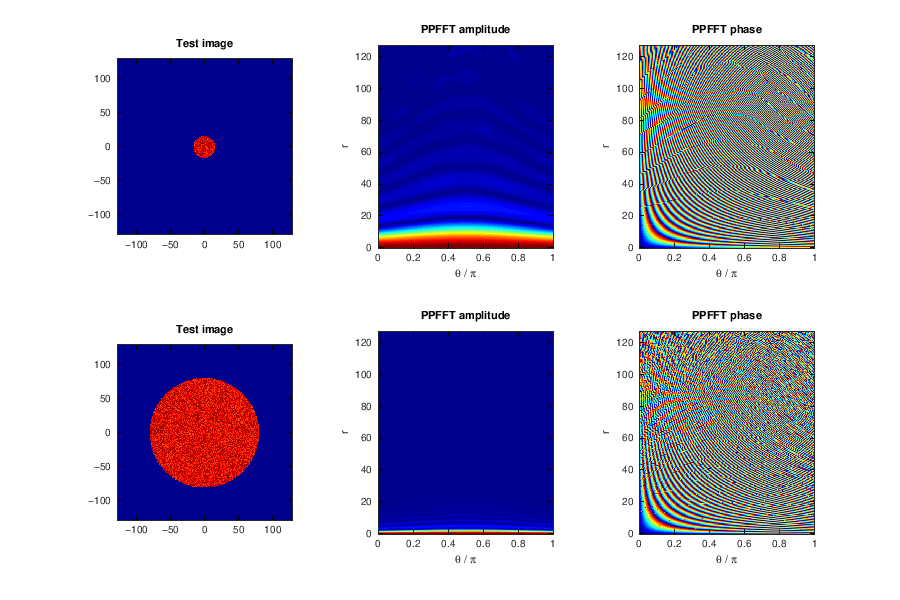

In [8]:
clear;
N=128;
oversample=3;    % PPFFT setting, useful range = 1..5
t_shuffle=[oversample*2*N:-1:1];
r_shuffle=[oversample*2*N:-1:oversample*N];

m = zeros(2*N);
f=[1/8 5/8];
blob=[-f(1)*N:f(1)*N];

% a filled circle in the middle + noise
m(N+blob,N+blob) += ifelse(abs(blob.^2 + blob.^2') < (f(1)*N)^2,...
                    (200 + 55*rand(size(m(N+blob,N+blob)))),0);

I=m;
subplot(2,3,1);
imagesc([-N:N],[-N:N],I); 
axis("xy"); title("Test image"); pbaspect([1 1 1]);
tic; I_ft=PPFFT(I,oversample,oversample); toc;
I_p=abs(I_ft(r_shuffle,t_shuffle));
subplot(2,3,2);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT amplitude"); xlabel("\\theta / \\pi"); ylabel("r");
I_p=angle(I_ft(r_shuffle,t_shuffle));
I_p += ifelse(I_p<0,pi,0);  % fix up the phase for arctan() to 0..2*pi
subplot(2,3,3);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT phase"); xlabel("\\theta / \\pi"); ylabel("r");

% a different-size circle
m = zeros(2*N);
blob=[-f(2)*N:f(2)*N];
m(N+blob,N+blob) += ifelse(abs(blob.^2 + blob.^2') < (f(2)*N)^2,...
                    (200 + 55*rand(size(m(N+blob,N+blob)))),0);

I=m;
subplot(2,3,4);
imagesc([-N:N],[-N:N],I); 
axis("xy"); title("Test image"); pbaspect([1 1 1]);
tic; I_ft=PPFFT(I,oversample,oversample); toc;
I_p=abs(I_ft(r_shuffle,t_shuffle));
subplot(2,3,5);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT amplitude"); xlabel("\\theta / \\pi"); ylabel("r");
I_p=angle(I_ft(r_shuffle,t_shuffle));
I_p += ifelse(I_p<0,pi,0);  % fix up the phase for arctan() to 0..2*pi
subplot(2,3,6);
imagesc(linspace(0,1,N),[0:N-1],I_p); 
axis("xy"); title("PPFFT phase"); xlabel("\\theta / \\pi"); ylabel("r");

colormap("jet");

# Homework

  * Carefully read the entire paper.

  * Explore the sample script (see below) and play with its various parameters to build intuition into the properties of the 1D Fourier Transform. Vary the width, position, and if possible shape of pulses (windowing functions) in the  time domain, and see how the FT changes. Do this before you proceed with the next item in the homework.

  * Create a family of test images that represent a cosinusoidal wave emanating radially from the centre in all directions, decaying with a Gaussian envelope as a function of the radial distance from the center. Postulate what a 2D FT in polar coordinates should look like for such test images, and perform the PPFFT.  Was your initial guess correct?

  * Vary parameters of your test file: rate of Gaussian decay of signal intensity, size of the test image, level of random noise added, the execution time, the map of phase errors, etc. Choose one interesting aspect to explore extensively (hopefully, everyone will choose a different aspect of the script) and prepare a summary table (and a plot, if appropriate) of your findings. Reflect and discuss the result in your conclusions.

  * See if you can measure the spacing of interference lines obtained in PHYS 3P91 experiments by using FFT. Sample images can be found in <code>/work/5P10/Images</code>. Use appropriate forms of FFT, depending on the image.

  * Prepare and submit a full project write-up, as a Jupyter notebook, by November 23, 2023.

In [9]:
%plot --format svg -w 900 -h 600

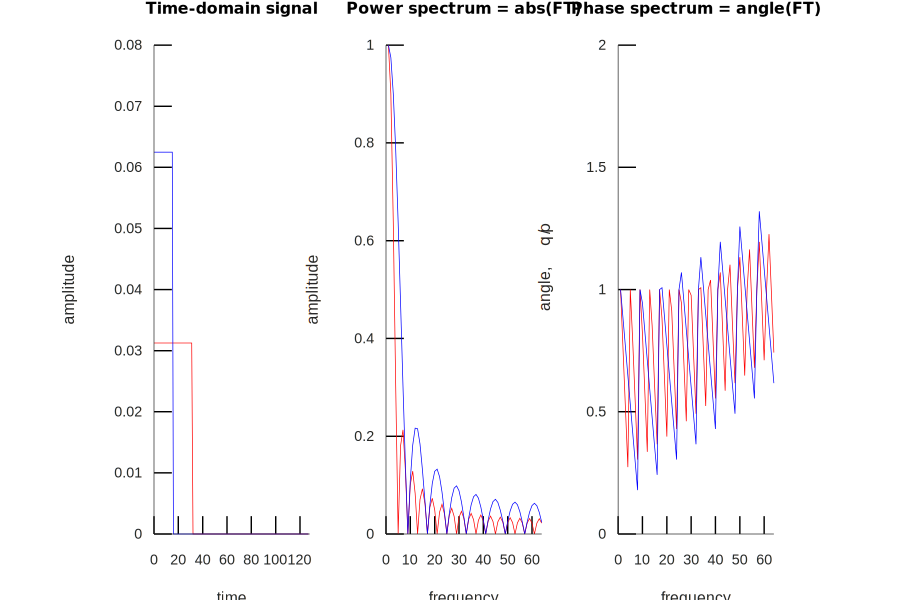

In [10]:
N=128;
x=[0:N-1];

% a test time-domain signal, consists of two square pulses
%y1=ifelse((x>24 & x<=40),1/16,0);
%y2=ifelse((x>64 & x<=72), 1/8, 0);

% another combination of two pulses 
y1=ifelse((x<32),1/32,0);
y2=ifelse((x<16), 1/16, 0);

figure(1); clf(1);

subplot(1,3,1);
hold on;
plot(x,y1,'r-');
plot(x,y2,'b-');
xlim([0 N]);
xlabel("time");
ylabel("amplitude");
title("Time-domain signal")
hold off;

f1=fft(y1);
f2=fft(y2);

subplot(1,3,2);
hold on;
plot(abs(f1),'r-');
plot(abs(f2),'b-');
xlim([0 N/2]);
xlabel("frequency");
ylabel("amplitude");
title("Power spectrum = abs(FT)")
hold off;

subplot(1,3,3);
hold on;
p1=angle(f1);
p2=angle(f2);
% optionally, shift phase from -pi..pi, to 0..2*pi
p1+=pi;
p2+=pi;
p1+=ifelse(p1>2*pi,-2*pi,0);
p2+=ifelse(p2>2*pi,-2*pi,0);

plot(p1/pi,'r-');
plot(p2/pi,'b-');
xlim([0 N/2]);
xlabel("frequency");
ylabel("angle, \\theta/\\pi");
title("Phase spectrum = angle(FT)")
hold off;